In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import warnings
warnings.simplefilter('ignore')
sns.set(rc={'figure.figsize' : (12, 6)})
sns.set_style("darkgrid", {'axes.grid' : True})

%matplotlib inline

In [2]:
data = pd.read_csv('review_db.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
#one hot encoding
data['sentiment'] = label_encoder.fit_transform(data['sentiment'])
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
import string
import re
import nltk
from nltk.corpus import stopwords


#쓸데없는 글자 제거
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

#불용어 제거
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]


data['review'] = data['review'].str.replace('<br />',' ')
data['review'] = data['review'].apply(lambda x:clean_text(x))
data['review'] = data['review'].apply(lambda x:remove_stopword(x))

data.head()

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

def ngram_vectorize(texts, labels):
    kwargs = {'ngram_range' : (1, 2),'dtype' : 'int32','strip_accents' : 'unicode',
              'decode_error' : 'replace','analyzer' : 'word','min_df' : 2}

    #tf-idf로 vectorize
    tfidf_vectorizer = TfidfVectorizer(**kwargs)
    transformed_texts = tfidf_vectorizer.fit_transform(texts)
    
    # selector를 이용하여, vector화된 값들을 최적화  
    selector = SelectKBest(f_classif, k=min(20000, transformed_texts.shape[1]))
    selector.fit(transformed_texts, labels)
    transformed_texts = selector.transform(transformed_texts).astype('float32')

    return transformed_texts


from sklearn.feature_extraction.text import TfidfVectorizer
#벡터화
vect_data = ngram_vectorize(data['review'], data['sentiment'])
tfidf = TfidfVectorizer()
tr_texts = tfidf.fit_transform(data['review'])

In [5]:
vect_data

<50000x20000 sparse matrix of type '<class 'numpy.float32'>'
	with 7184142 stored elements in Compressed Sparse Row format>

In [8]:
from sklearn.model_selection import train_test_split

# 데이터 분할 (학습, 테스트)
X = vect_data.toarray()
y = (np.array(data['sentiment']))

#학습 80%, 테스트 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [9]:
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

LEARNING_RATE = 1e-3
DROPOUT_RATE = 0.2
UNITS = 64

#sequence구축
model = keras.Sequential()
model.add(Dropout(rate= DROPOUT_RATE, input_shape = X_train.shape[1:]))
model.add(Dense(units=UNITS, activation='relu'))
model.add(Dropout(rate=DROPOUT_RATE))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

#조기종료를 위한 콜백
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 19133)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1224576   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,224,641
Trainable params: 1,224,641
Non-trainable params: 0
_________________________________________________________________


In [10]:
#학습횟수, 학습배치사이즈
EPOCHS = 100
BATCH_SIZE = 128

#학습시작
history = model.fit(X_train, y_train, epochs=EPOCHS,
                    validation_data=(X_test, y_test), verbose=1,
                    batch_size=BATCH_SIZE, callbacks=callbacks)

Train on 400 samples, validate on 100 samples
Epoch 1/100
400/400 [==============================] - 1s 3ms/sample - loss: 0.6919 - acc: 0.4750 - val_loss: 0.6858 - val_acc: 0.6700
Epoch 2/100
400/400 [==============================] - 0s 492us/sample - loss: 0.6617 - acc: 0.9625 - val_loss: 0.6703 - val_acc: 0.9200
Epoch 3/100
400/400 [==============================] - 0s 515us/sample - loss: 0.6206 - acc: 0.9950 - val_loss: 0.6514 - val_acc: 0.9000
Epoch 4/100
400/400 [==============================] - 0s 567us/sample - loss: 0.5728 - acc: 1.0000 - val_loss: 0.6327 - val_acc: 0.8900
Epoch 5/100
400/400 [==============================] - 0s 510us/sample - loss: 0.5266 - acc: 0.9975 - val_loss: 0.6141 - val_acc: 0.9200
Epoch 6/100
400/400 [==============================] - 0s 497us/sample - loss: 0.4816 - acc: 1.0000 - val_loss: 0.5956 - val_acc: 0.9300
Epoch 7/100
400/400 [==============================] - 0s 490us/sample - loss: 0.4354 - acc: 1.0000 - val_loss: 0.5772 - val_acc: 0.93

In [8]:
# 모델을 이용하여, test정확도 측정
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

10000/10000 [==============================] - 2s 161us/sample - loss: 0.1805 - acc: 0.9325
Test loss: 0.18045720897912979
Test accuracy: 0.9325


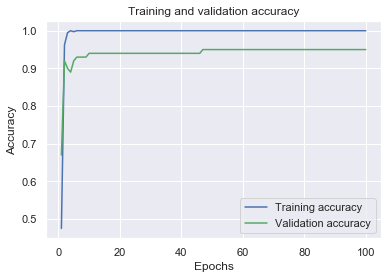

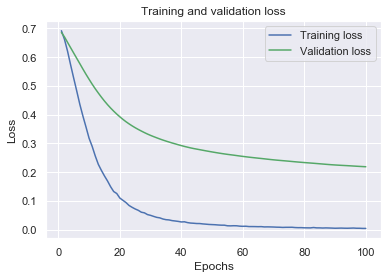

In [11]:
#결과 그래프
def plot_history(history):
    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1,len(accuracy) + 1)
    
    # Plot accuracy  
    plt.figure(1)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.figure(2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history)

In [10]:
#모델저장
model.save('IMDB_model.h5')